In [1]:
#imports

from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np
from tempfile import TemporaryFile
import matplotlib.pyplot as plt
import matplotlib
import os
import pickle
import random 
import operator
import math
import numpy as np
import os
import pandas as pd
import IPython.display as ipd
import librosa
import librosa.display
from scipy.signal import blackman
from scipy.fft import fft, fftfreq

from miniesn_MBK import *
from numpy.random import randint, uniform, normal
import scipy.sparse as sparse
import scipy.sparse.linalg as sparse_linalg
import scipy.linalg as la

from scipy.integrate import trapz
from scipy.stats import norm

# %matplotlib widget: make plots interactive
matplotlib.use('nbagg') 
# matplotlib.rcParams['figure.figsize']=(24,5)
matplotlib.rcParams['figure.figsize']=(6,3)

from tqdm import tqdm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# %load_ext jupyternotify

In [2]:
x,sr=0,0
def calculate_onset(x=x, sr=sr):
    onset_env = librosa.onset.onset_strength(x, sr=sr, aggregate=np.median, hop_length = 512)
    times = librosa.times_like(onset_env, sr=sr, hop_length=512)
    return onset_env, times

def tempo_and_beats(x=x, sr=sr):
    tempo, beats = librosa.beat.beat_track(y=x, sr=sr)
    return tempo, beats

def beat_times(x=x, sr=sr):
#     onset_env,_=calculate_onset(x, sr=sr)
    _,beats = tempo_and_beats(x, sr=sr)
    beattimes = np.zeros_like(onset_env)
    beattimes[beats]=1
    return beattimes

def separate_harmonic_and_rythmic(x=x, sr=sr):
    D = np.abs(librosa.stft(x))
    H,P=librosa.decompose.hpss(D)
    return H,P

def invert_spectrogram_to_audio(S):
    y=librosa.griffinlim(S)
    return y

def tempo_and_beats_harmonic(x=x,sr=sr):
    H,_ = separate_harmonic_and_rythmic(x, sr)
    y_harmonic = invert_spectrogram_to_audio(H)
    tempo_harmonic, beats_harmonic = tempo_and_beats(y_harmonic, sr)
    return tempo_harmonic, beats_harmonic

def tempo_and_beats_percussive(x=x,sr=sr):
    _,P = separate_harmonic_and_rythmic(x, sr)
    y_percussive = invert_spectrogram_to_audio(P)
    tempo_percussive, beats_percussive = tempo_and_beats(y_percussive, sr)
    return tempo_percussive, beats_percussive

def beat_times_harmonic(x=x, sr=sr):
    H,_ = separate_harmonic_and_rythmic(x, sr)
    y_harmonic = invert_spectrogram_to_audio(H)
    beattimes_harmonic = beat_times(y_harmonic, sr)
    return beattimes_harmonic

def beat_times_percussive(x=x, sr=sr):
    _,P = separate_harmonic_and_rythmic(x, sr)
    y_percussive = invert_spectrogram_to_audio(P)
    beattimes_percussive = beat_times(y_percussive, sr)
    return beattimes_percussive

def calc_onbeat(x=x, sr=sr):
    onset_env, times = calculate_onset(x, sr)
    beattimes = beat_times(x, sr)
    dt = times[1]-times[0]
    int_onset_env = trapz(onset_env, dx=dt)
    int_beattimes = trapz(beattimes,dx=dt)
    int_onset_env_onbeat = trapz(onset_env*beattimes, dx=dt)
    return int_onset_env_onbeat/(int_beattimes*int_onset_env)
 
def calc_onbeat_harmonic_percussive(x=x, sr=sr):
    H,P = separate_harmonic_and_rythmic(x=x, sr=sr)
    y_harmonic = invert_spectrogram_to_audio(H)
    y_percussive = invert_spectrogram_to_audio(P)
    onset_env_harmonic, times = calculate_onset(y_harmonic, sr)    
    onset_env_percussive, _ = calculate_onset(y_percussive, sr)
    beattimes_harmonic = beat_times_harmonic(x=x, sr=sr)
    beattimes_percussive = beat_times_percussive(x=x, sr=sr)
    
    int_onset_env_harmonic = trapz(onset_env_harmonic, dx=dt)
    int_beattimes_harmonic = trapz(beattimes_harmonic, dx=dt)
    int_onset_env_onbeat_harmonic = trapz(onset_env_harmonic*beattimes_harmonic, dx=dt)
    frac_onbeat_harmonic = int_onset_env_onbeat_harmonic/(int_beattimes_harmonic*int_onset_env_harmonic)
    
    int_onset_env_percussive = trapz(onset_env_percussive, dx=dt)
    int_beattimes_percussive = trapz(beattimes_percussive, dx=dt)
    int_onset_env_onbeat_percussive = trapz(onset_env_percussive*beattimes_percussive, dx=dt)
    frac_onbeat_percussive = int_onset_env_onbeat_percussive/(int_beattimes_percussive*int_onset_env_percussive)
    return frac_onbeat_harmonic, frac_onbeat_percussive
    
def getPSD(y, N, dt):
    w=blackman(N)
    PSD=(dt/N)*abs(np.fft.rfft(y*w))**2
    f=np.fft.rfftfreq(N,d=dt)
    return f, PSD



In [3]:
# dpath = r'C:\Users\MBK\OneDrive\Documents\uni\phd\AppliedMachineLearning2021\AppliedML2021\BigProject\audio\homemade'
genre_folder = os.path.join('music','genres')
genres = os.listdir(os.path.join(os.path.abspath(''),'..',genre_folder))
genres.remove('my.dat')

In [ ]:
# ii=0
# song_id = []
# genre_data = []
# tempo_data = []
# tempo_harmonic_data = []
# tempo_percussive_data = []
# onbeat_data = []
# onbeat_harmonic_data = []
# onbeat_percussive_data = []
# for genre in genres:
#     dpath=os.path.abspath(os.path.join(os.path.abspath(''),'..',os.path.join(genre_folder,genre)))
#     print(dpath)
#     songs = os.listdir(dpath)
#     for song in songs:
#         if genre in song:
#             ii+=1
#             print('song %d of %d' %(ii, len(songs)))
#             x, sr = librosa.load(os.path.join(dpath, song))
#             onset_env = librosa.onset.onset_strength(x, sr=sr, aggregate=np.median, hop_length = 512)
#             times = librosa.times_like(onset_env, sr=sr, hop_length=512)
#             tempo, beats = librosa.beat.beat_track(y=x, sr=sr)
#             beattimes = np.zeros_like(onset_env)
#             beattimes[beats]=1
#             dt = times[1]-times[0]
#             onbeat = trapz(onset_env*beattimes, dx=dt)/( trapz(beattimes,dx=dt)*trapz(onset_env, dx=dt))
            
#             H,P=separate_harmonic_and_rythmic(x=x, sr=sr)
#             y_harmonic = invert_spectrogram_to_audio(H)
#             y_percussive = invert_spectrogram_to_audio(P)
#             onset_env_harmonic = librosa.onset.onset_strength(y_harmonic, sr=sr, aggregate=np.median, hop_length = 512)
#             onset_env_percussive = librosa.onset.onset_strength(y_percussive, sr=sr, aggregate=np.median, hop_length = 512)
#             tempo_harmonic, beats_harmonic = librosa.beat.beat_track(y=y_harmonic, sr=sr)
#             tempo_percussive, beats_percussive = librosa.beat.beat_track(y=y_percussive, sr=sr)
#             beattimes_harmonic = np.zeros_like(onset_env_harmonic)
#             beattimes_harmonic[beats_harmonic]=1
#             beattimes_percussive = np.zeros_like(onset_env_percussive)
#             beattimes_percussive[beats_percussive]=1
            
            
#             onbeat_harmonic = trapz(onset_env_harmonic*beattimes_harmonic, dx=dt)/( trapz(beattimes_harmonic,dx=dt)*trapz(onset_env_harmonic, dx=dt))
#             onbeat_percussive = trapz(onset_env_percussive*beattimes_percussive, dx=dt)/( trapz(beattimes_percussive,dx=dt)*trapz(onset_env_percussive, dx=dt))
            
            
# #             tempo, beats = tempo_and_beats(x=x, sr=sr)
# #             onbeat = calc_onbeat(x=x, sr=sr)
# #             tempo_harmonic,_ = tempo_and_beats_harmonic(x, sr)
# #             tempo_percussive,_ = tempo_and_beats_percussive(x, sr)
# #             onbeat_harmonic, onbeat_percussive = calc_onbeat_harmonic_percussive(x, sr)
            
#             genre_data.append(genre)
#             song_id.append(ii)
#             tempo_data.append(tempo)
#             onbeat_data.append(onbeat)
            
#             tempo_harmonic_data.append(tempo_harmonic)
#             tempo_percussive_data.append(tempo_percussive)
#             onbeat_harmonic_data.append(onbeat_harmonic)
#             onbeat_percussive_data.append(onbeat_percussive)
    

In [186]:
ii=0
song_id = []
genre_data = []

overlap0_data = []

overlap1_data = []
overlap1Early_data = []
overlap1Late_data = []

overlap2_data = []
overlap2Early_data = []
overlap2Late_data = []

overlap3_data = []
overlap3Early_data = []
overlap3Late_data = []

overlap4_data = []
overlap4Early_data = []
overlap4Late_data = []

overlap5_data = []
overlap5Early_data = []
overlap5Late_data = []

overlap6_data = []
overlap6Early_data = []
overlap6Late_data = []

for genre in genres:
    dpath=os.path.abspath(os.path.join(os.path.abspath(''),'..',os.path.join(genre_folder,genre)))
    print(dpath)
    songs = os.listdir(dpath)
    for song in songs:
        if genre in song:
            ii+=1
            x, sr = librosa.load(os.path.join(dpath, song))
            print('song %d of %d' %(ii, len(songs*len(genres))))
            
            onset,times = calculate_onset(x=x, sr=sr)
            tempo, beats = tempo_and_beats(x=x, sr=sr)
            f, psd = getPSD(onset, len(onset), times[1]-times[0])
            fBeats = f/(tempo/60)
            fplot = fBeats
            
            delta = 0.045
            sig = 0.015
            
            df = fplot[1]-fplot[0]

            overlap0 = 2*trapz(norm(loc=0, scale = sig).pdf(fplot)*psd, dx = df)

            overlap1 = trapz(norm(loc=1, scale = sig).pdf(fplot)*psd, dx = df)
            overlap1Early = trapz(norm(loc=1-0.5*delta, scale = 0.5*sig).pdf(fplot)*psd, dx = df)
            overlap1Late = trapz(norm(loc=1+0.5*delta, scale = 0.5*sig).pdf(fplot)*psd, dx = df)

            overlap2 = trapz(norm(loc=2, scale = sig).pdf(fplot)*psd, dx = df)
            overlap2Early = trapz(norm(loc=2-delta, scale = sig).pdf(fplot)*psd, dx = df)
            overlap2Late = trapz(norm(loc=2+delta, scale = sig).pdf(fplot)*psd, dx = df)

            overlap3 = trapz(norm(loc=3, scale = sig).pdf(fplot)*psd, dx = df)
            overlap3Early = trapz(norm(loc=3-1.5*delta, scale = 1.5*sig).pdf(fplot)*psd, dx = df)
            overlap3Late = trapz(norm(loc=3+1.5*delta, scale = 1.5*sig).pdf(fplot)*psd, dx = df)

            overlap4 = trapz(norm(loc=4, scale = 2*sig).pdf(fplot)*psd, dx = df)
            overlap4Early = trapz(norm(loc=4-2*delta, scale = 2*sig).pdf(fplot)*psd, dx = df)
            overlap4Late = trapz(norm(loc=4+2*delta, scale = 2*sig).pdf(fplot)*psd, dx = df)

            overlap5 = trapz(norm(loc=5, scale = 2.5*sig).pdf(fplot)*psd, dx = df)
            overlap5Early = trapz(norm(loc=5-2.5*delta, scale = 2.5*sig).pdf(fplot)*psd, dx = df)
            overlap5Late = trapz(norm(loc=5+2.5*delta, scale = 2.5*sig).pdf(fplot)*psd, dx = df)

            overlap6 = trapz(norm(loc=6, scale = 3*sig).pdf(fplot)*psd, dx = df)
            overlap6Early = trapz(norm(loc=6-3*delta, scale = 3*sig).pdf(fplot)*psd, dx = df)
            overlap6Late = trapz(norm(loc=6+3*delta, scale = 3*sig).pdf(fplot)*psd, dx = df)
            
            
            
            genre_data.append(genre)
            song_id.append(ii)
            overlap0_data.append(overlap0)
            
            overlap1_data.append(overlap1)
            overlap1Early_data.append(overlap1Early)
            overlap1Late_data.append(overlap1Late)

            overlap2_data.append(overlap2)
            overlap2Early_data.append(overlap2Early)
            overlap2Late_data.append(overlap2Late)

            overlap3_data.append(overlap3)
            overlap3Early_data.append(overlap3Early)
            overlap3Late_data.append(overlap3Late)

            overlap4_data.append(overlap4)
            overlap4Early_data.append(overlap4Early)
            overlap4Late_data.append(overlap4Late)

            overlap5_data.append(overlap5)
            overlap5Early_data.append(overlap5Early)
            overlap5Late_data.append(overlap5Late)

            overlap6_data.append(overlap6)
            overlap6Early_data.append(overlap6Early)
            overlap6Late_data.append(overlap6Late)
            
 

C:\Users\MBK\OneDrive\Documents\uni\phd\AppliedMachineLearning2021\ML2021BigProject\music\genres\blues
song 1 of 1020
song 2 of 1020
song 3 of 1020
song 4 of 1020
song 5 of 1020
song 6 of 1020
song 7 of 1020
song 8 of 1020
song 9 of 1020
song 10 of 1020
song 11 of 1020
song 12 of 1020
song 13 of 1020
song 14 of 1020
song 15 of 1020
song 16 of 1020
song 17 of 1020
song 18 of 1020
song 19 of 1020
song 20 of 1020
song 21 of 1020
song 22 of 1020
song 23 of 1020
song 24 of 1020
song 25 of 1020
song 26 of 1020
song 27 of 1020
song 28 of 1020
song 29 of 1020
song 30 of 1020
song 31 of 1020
song 32 of 1020
song 33 of 1020
song 34 of 1020
song 35 of 1020
song 36 of 1020
song 37 of 1020
song 38 of 1020
song 39 of 1020
song 40 of 1020
song 41 of 1020
song 42 of 1020
song 43 of 1020
song 44 of 1020
song 45 of 1020
song 46 of 1020
song 47 of 1020
song 48 of 1020
song 49 of 1020
song 50 of 1020
song 51 of 1020
song 52 of 1020
song 53 of 1020
song 54 of 1020
song 55 of 1020
song 56 of 1020
song 57 of

song 459 of 1000
song 460 of 1000
song 461 of 1000
song 462 of 1000
song 463 of 1000
song 464 of 1000
song 465 of 1000
song 466 of 1000
song 467 of 1000
song 468 of 1000
song 469 of 1000
song 470 of 1000
song 471 of 1000
song 472 of 1000
song 473 of 1000
song 474 of 1000
song 475 of 1000
song 476 of 1000
song 477 of 1000
song 478 of 1000
song 479 of 1000
song 480 of 1000
song 481 of 1000
song 482 of 1000
song 483 of 1000
song 484 of 1000
song 485 of 1000
song 486 of 1000
song 487 of 1000
song 488 of 1000
song 489 of 1000
song 490 of 1000
song 491 of 1000
song 492 of 1000
song 493 of 1000
song 494 of 1000
song 495 of 1000
song 496 of 1000
song 497 of 1000
song 498 of 1000
song 499 of 1000
song 500 of 1000
C:\Users\MBK\OneDrive\Documents\uni\phd\AppliedMachineLearning2021\ML2021BigProject\music\genres\jazz
song 501 of 1000
song 502 of 1000
song 503 of 1000
song 504 of 1000
song 505 of 1000
song 506 of 1000
song 507 of 1000
song 508 of 1000
song 509 of 1000
song 510 of 1000
song 511 of 10

song 911 of 1000
song 912 of 1000
song 913 of 1000
song 914 of 1000
song 915 of 1000
song 916 of 1000
song 917 of 1000
song 918 of 1000
song 919 of 1000
song 920 of 1000
song 921 of 1000
song 922 of 1000
song 923 of 1000
song 924 of 1000
song 925 of 1000
song 926 of 1000
song 927 of 1000
song 928 of 1000
song 929 of 1000
song 930 of 1000
song 931 of 1000
song 932 of 1000
song 933 of 1000
song 934 of 1000
song 935 of 1000
song 936 of 1000
song 937 of 1000
song 938 of 1000
song 939 of 1000
song 940 of 1000
song 941 of 1000
song 942 of 1000
song 943 of 1000
song 944 of 1000
song 945 of 1000
song 946 of 1000
song 947 of 1000
song 948 of 1000
song 949 of 1000
song 950 of 1000
song 951 of 1000
song 952 of 1000
song 953 of 1000
song 954 of 1000
song 955 of 1000
song 956 of 1000
song 957 of 1000
song 958 of 1000
song 959 of 1000
song 960 of 1000
song 961 of 1000
song 962 of 1000
song 963 of 1000
song 964 of 1000
song 965 of 1000
song 966 of 1000
song 967 of 1000
song 968 of 1000
song 969 of 10

<IPython.core.display.Javascript object>


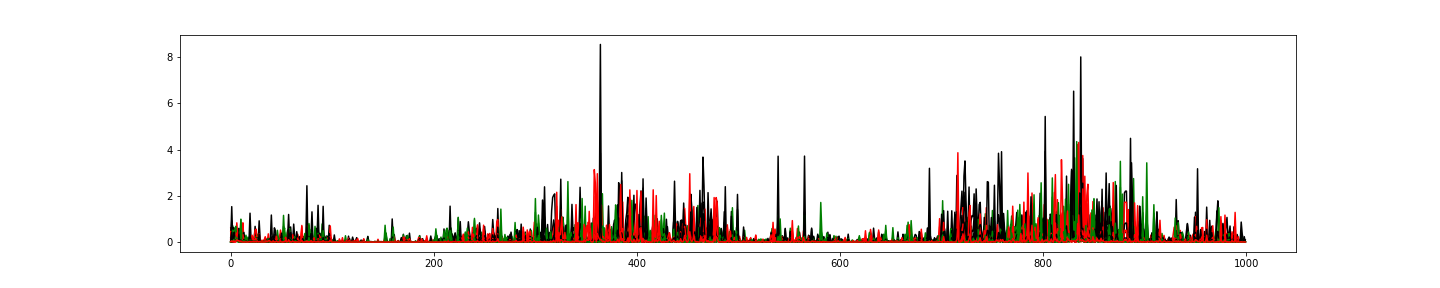

In [187]:
plt.figure()
plt.plot(overlap0, 'b')
plt.plot(overlap1_data,'k')
plt.plot(overlap1Early_data,'g')
plt.plot(overlap1Late_data ,'r')

plt.plot(overlap2_data,'k')
plt.plot(overlap2Early_data,'g')
plt.plot(overlap2Late_data ,'r')

plt.plot(overlap3_data,'k')
plt.plot(overlap3Early_data,'g')
plt.plot(overlap3Late_data ,'r')

plt.plot(overlap4_data,'k')
plt.plot(overlap4Early_data,'g')
plt.plot(overlap4Late_data ,'r')

plt.plot(overlap5_data,'k')
plt.plot(overlap5Early_data,'g')
plt.plot(overlap5Late_data ,'r')

plt.plot(overlap6_data,'k')
plt.plot(overlap6Early_data,'g')
plt.plot(overlap6Late_data ,'r')

In [202]:
# # print(onbeat_harmonic_data)
# dataarray=np.array([np.array(song_id),np.array(genre_data),np.array(tempo_data),np.array(tempo_harmonic_data),np.array(tempo_percussive_data),np.array(onbeat_data),np.array(onbeat_harmonic_data),np.array(onbeat_percussive_data)]).T
# dataDF = pd.DataFrame(dataarray, columns=['songID','genre','tempo','tempoHarmonic', 'tempoPercussive','onBeat','onBeatHarmonic','onBeatPercussive'])
# # outputdata = pd.DataFrame(columns=np.array([np.array(song_id),np.array(genre_data),np.array(tempo_data),np.array(tempo_harmonic_data),np.array(tempo_percussive_data),np.array(onbeat_data),np.array(onbeat_harmonic_data),np.array(onbeat_percussive_data)]))
# # outputdata
# # np.array([np.array(song_id),np.array(genre_data),np.array(tempo_data),np.array(tempo_harmonic_data),np.array(tempo_percussive_data),np.array(onbeat_data),np.array(onbeat_harmonic_data),np.array(onbeat_percussive_data)])
# dataarray
# dataDF.to_csv('rythmic_data.csv',index=False)

# print(onbeat_harmonic_data)
dataarray=np.array([
    np.array(song_id),np.array(genre_data), 
    np.array(overlap0_data),
                    np.array(overlap1_data),np.array(overlap1Early_data),np.array(overlap1Late_data),
                    np.array(overlap2_data),np.array(overlap2Early_data),np.array(overlap2Late_data),
                    np.array(overlap3_data),np.array(overlap3Early_data),np.array(overlap3Late_data),
                    np.array(overlap4_data),np.array(overlap4Early_data),np.array(overlap4Late_data),
                    np.array(overlap5_data),np.array(overlap5Early_data),np.array(overlap5Late_data),
                    np.array(overlap6_data),np.array(overlap6Early_data),np.array(overlap6Late_data)
                   ]).T
# dataDF=pd.DataFrame(dataarray)
dataDF = pd.DataFrame(dataarray,
                      columns=['songID','genre','overlap0','overlap1', 'overlap1Early','overlap1Late','overlap2', 'overlap2Early','overlap2Late','overlap3', 'overlap3Early','overlap3Late', 'overlap4', 'overlap4Early','overlap4Late', 'overlap5', 'overlap5Early','overlap5Late', 'overlap6', 'overlap6Early','overlap6Late']
                     )
# outputdata = pd.DataFrame(columns=np.array([np.array(song_id),np.array(genre_data),np.array(tempo_data),np.array(tempo_harmonic_data),np.array(tempo_percussive_data),np.array(onbeat_data),np.array(onbeat_harmonic_data),np.array(onbeat_percussive_data)]))
# outputdata
# np.array([np.array(song_id),np.array(genre_data),np.array(tempo_data),np.array(tempo_harmonic_data),np.array(tempo_percussive_data),np.array(onbeat_data),np.array(onbeat_harmonic_data),np.array(onbeat_percussive_data)])
# dataarray
dataDF
# dataDF.to_csv('syncopation_data.csv',index=False)

In [4]:
desiredGenre = 'blues'
desiredfolder=os.path.join('music','genres',desiredGenre)
dpath = os.path.abspath(os.path.join(os.path.abspath(''), '..', desiredfolder))
dfiles = os.listdir(dpath)

<IPython.core.display.Javascript object>


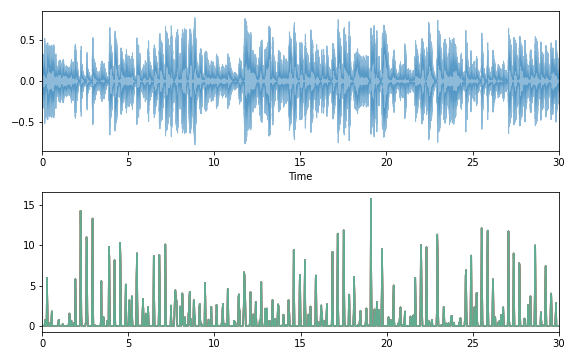

In [5]:
fileselect=12
x, sr = librosa.load(os.path.join(dpath, dfiles[fileselect])) 
waveformTime = np.arange(start=0, stop=len(x)/sr, step=1/sr) 
figwaveform=plt.figure('view waveform',figsize=(8,5)) 
figwaveform.clf()
ax=figwaveform.add_subplot(211)
librosa.display.waveplot(x,alpha=.5,ax=ax) 
# plt.grid()
# plt.xlabel('Time (s)')
figwaveform.show()

figwaveform.tight_layout() 

In [84]:
ax.set_ylabel('Raw Waveform')
ax2.set_ylabel('Onset Envelope')
# figwaveform.savefig(str('Waveform_and_onset'+desiredGenre+str(fileselect)+'.png')) 
ipd.Audio(x, rate=sr)

sf.write(desiredGenre+str(fileselect)+'_5secsnip.wav',x[:int(len(x)/6)], samplerate=sr)
#blues54 after the beat #disco4 before beat

In [8]:
D = np.abs(librosa.stft(x))
times = librosa.times_like(D)

<ipython-input-15-d5f7fa0dfc47>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 =figwaveform.add_subplot(212)


<IPython.core.display.Javascript object>


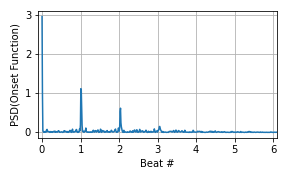

21.533203125

In [15]:
onset,times = calculate_onset(x=x, sr=sr)
tempo, beats = tempo_and_beats(x=x, sr=sr)

ax2 =figwaveform.add_subplot(212)
ax2.plot(times,onset,alpha=0.5)
figwaveform.tight_layout()
ax2.set_xlim([0,30])

f, psd = getPSD(onset, len(onset), times[1]-times[0])
fBeats = f/(tempo/60)
# fplot = np.linspace(0,8,4000)
fplot=fBeats
delta = 0.045
sig = 0.015
plt.figure('onsetPSD',figsize=(4,2.5))
plt.plot(fBeats,psd)
# plt.plot(fplot,0.02*norm(loc=2, scale = sig).pdf(fplot), 'k')
# plt.plot(fplot,0.02*norm(loc=2+delta, scale = sig).pdf(fplot), 'red')
# plt.plot(fplot,0.02*norm(loc=2-delta, scale = sig).pdf(fplot), 'green')

# plt.plot(fplot,0.02*norm(loc=4, scale = 2*sig).pdf(fplot), 'k')
# plt.plot(fplot,0.02*norm(loc=4+2*delta, scale = 2*sig).pdf(fplot), 'red')
# plt.plot(fplot,0.02*norm(loc=4-2*delta, scale = 2*sig).pdf(fplot), 'green')

# plt.plot(fplot,0.02*norm(loc=6, scale = 3*sig).pdf(fplot), 'k')
# plt.plot(fplot,0.02*norm(loc=6+3*delta, scale = 3*sig).pdf(fplot), 'red')
# plt.plot(fplot,0.02*norm(loc=6-3*delta, scale = 3*sig).pdf(fplot), 'green')

ax=plt.gca()
ax.grid()
# ax.set_xticks([0,4,8,12,16])
ax.set_xticks([0,1,2,3,4,5,6,7,8])
# plt.ylim([1e-3,2])
# plt.xlim([1.5,2.5])
plt.xlim([-0.1,6.1])
plt.ylabel('PSD(Onset Function)')
plt.xlabel('Beat #')
plt.tight_layout()
# plt.savefig(str('OnsetFunctionFFTBeats_gaussbeat4'+desiredGenre+str(fileselect)+'.png'), dpi=200) 
0.5/(times[1]-times[0])

In [ ]:
overlap0 = 2*trapz(norm(loc=0, scale = sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])

overlap1 = trapz(norm(loc=1, scale = sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])
overlap1Early = trapz(norm(loc=1-0.5*delta, scale = 0.5*sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])
overlap1Late = trapz(norm(loc=1+0.5*delta, scale = 0.5*sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])

overlap2 = trapz(norm(loc=2, scale = sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])
overlap2Early = trapz(norm(loc=2-delta, scale = sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])
overlap2Late = trapz(norm(loc=2+delta, scale = sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])

overlap3 = trapz(norm(loc=3, scale = sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])
overlap3Early = trapz(norm(loc=3-1.5*delta, scale = 1.5*sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])
overlap3Late = trapz(norm(loc=3+1.5*delta, scale = 1.5*sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])

overlap4 = trapz(norm(loc=4, scale = 2*sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])
overlap4Early = trapz(norm(loc=4-2*delta, scale = 2*sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])
overlap4Late = trapz(norm(loc=4+2*delta, scale = 2*sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])

overlap5 = trapz(norm(loc=5, scale = 2.5*sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])
overlap5Early = trapz(norm(loc=5-2.5*delta, scale = 2.5*sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])
overlap5Late = trapz(norm(loc=5+2.5*delta, scale = 2.5*sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])

overlap6 = trapz(norm(loc=6, scale = 3*sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])
overlap6Early = trapz(norm(loc=6-3*delta, scale = 3*sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])
overlap6Late = trapz(norm(loc=6+3*delta, scale = 3*sig).pdf(fplot)*psd, dx = fplot[1]-fplot[0])

print(overlap0) 
print(overlap1Early, overlap1, overlap1Late)
print(overlap2Early, overlap2, overlap2Late)
print(overlap3Early, overlap3, overlap3Late)
print(overlap4Early, overlap4, overlap4Late)
print(overlap5Early, overlap5, overlap5Late)
print(overlap6Early, overlap6, overlap6Late)

<IPython.core.display.Javascript object>


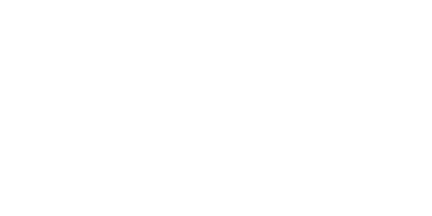

NameError: name 'overlap0' is not defined

In [85]:
plt.figure()
plt.plot([overlap0,overlap1,overlap2,overlap3,overlap4,overlap5,overlap6],'ko', linestyle = 'dashed', label='on beat')
plt.plot([overlap0,overlap1Early,overlap2Early,overlap3Early,overlap4Early,overlap5Early,overlap6Early],'go', linestyle = 'dashed', label='Early')
plt.plot([overlap0,overlap1Late,overlap2Late,overlap3Late,overlap4Late,overlap5Late,overlap6Late],'ro', linestyle = 'dashed', label='late')
plt.xlabel('Beat #')

<IPython.core.display.Javascript object>


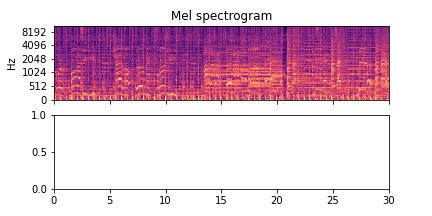

<IPython.core.display.Javascript object>


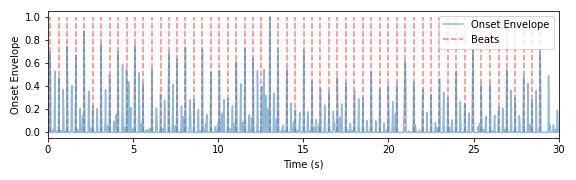

In [31]:
hop_length = 10
fig, ax = plt.subplots(nrows=2, sharex=True)
fig.figsize=(12,8)
# times = librosa.times_like(onset, sr=sr, hop_length=hop_length)
M = librosa.feature.melspectrogram(y=x, sr=sr, hop_length=hop_length)
librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time', hop_length=hop_length,
                         ax=ax[0])
ax[0].label_outer()
ax[0].set(title='Mel spectrogram')

hf=plt.figure('onset_function',figsize=(8,2.5))
ax=hf.add_subplot(111)
ax.plot(times, librosa.util.normalize(onset), alpha = 0.5,
         label='Onset Envelope')
ax.vlines(times[beats], 0, 1, alpha=0.5, color='r',
           linestyle='--', label='Beats')
ax.set_ylabel('Onset Envelope')
ax.set_xlabel('Time (s)')
ax.set_xlim([0,30])
ax.legend()
plt.tight_layout()
plt.savefig(str('OnsetFunctionBeatLines'+desiredGenre+str(fileselect)+'.png'), dpi=200) 

In [137]:
onset_env
beattimes = np.zeros_like(onset_env)
beattimes[beats]=1

In [101]:
norm(loc=2, scale = 0.1).pdf(fBeats)

array([5.52094836e-087, 1.03198570e-085, 1.88780015e-084, 3.37956414e-083,
       5.92089978e-082, 1.01516601e-080, 1.70336910e-079, 2.79706657e-078,
       4.49489118e-077, 7.06899868e-076, 1.08797511e-074, 1.63871097e-073,
       2.41550588e-072, 3.48446559e-071, 4.91911076e-070, 6.79609378e-069,
       9.18870830e-068, 1.21582735e-066, 1.57438771e-065, 1.99514201e-064,
       2.47433374e-063, 3.00306741e-062, 3.56692703e-061, 4.14615668e-060,
       4.71649670e-059, 5.25068180e-058, 5.72050285e-057, 6.09923059e-056,
       6.36411823e-055, 6.49865926e-054, 6.49428935e-053, 6.35128853e-052,
       6.07875152e-051, 5.69363051e-050, 5.21899054e-049, 4.68172693e-048,
       4.11005837e-047, 3.53111807e-046, 2.96892229e-045, 2.44291166e-044,
       1.96715705e-043, 1.55021754e-042, 1.19555235e-041, 9.02333107e-041,
       6.66480620e-040, 4.81759735e-039, 3.40797040e-038, 2.35930164e-037,
       1.59842942e-036, 1.05980460e-035, 6.87670629e-035, 4.36674159e-034,
       2.71366885e-033, 1

<IPython.core.display.Javascript object>


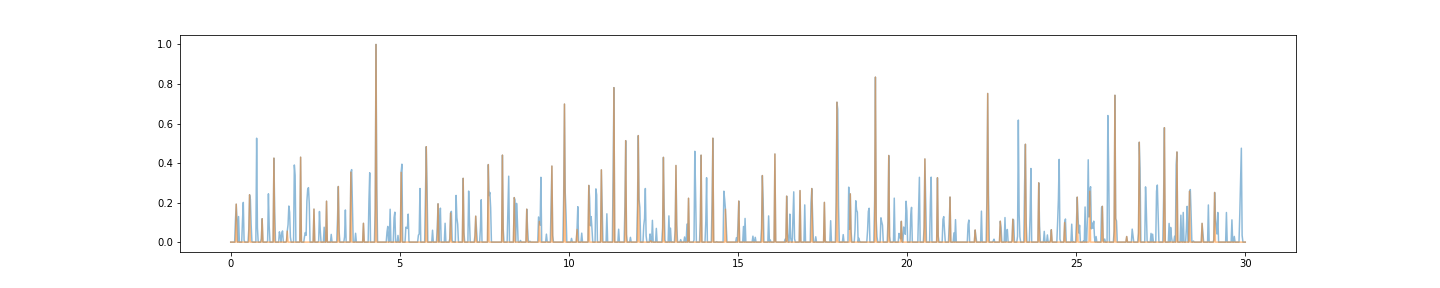

In [139]:
scaled_onset_env = librosa.util.normalize(onset_env)
plt.figure()
plt.clf()
plt.plot(times, scaled_onset_env,alpha=0.5)
plt.plot(times,scaled_onset_env*beattimes,alpha=0.5)

In [143]:
dt = times[1]-times[0]
int_onset_env = trapz(scaled_onset_env, dx=dt)
int_beattimes = trapz(beattimes,dx=dt)
int_onset_env_onbeat = trapz(scaled_onset_env*beattimes, dx=dt)

In [144]:
int_onset_env_onbeat/(int_beattimes*int_onset_env)

0.19121598

In [33]:
H,P=librosa.decompose.hpss(D)

<IPython.core.display.Javascript object>


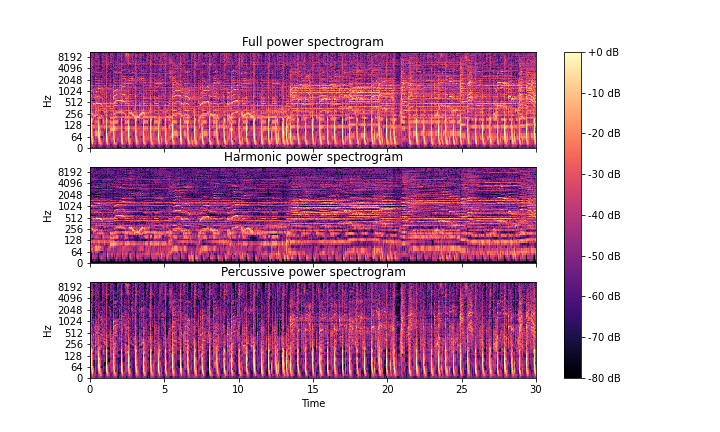

In [37]:
fig, ax = plt.subplots(figsize = (10,6),nrows=3, sharex=True, sharey=True)
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(D),
                                                       ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Full power spectrogram')
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(H),
                                                 ref=np.max(np.abs(D))),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Harmonic power spectrogram')
ax[1].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(P),
                                                 ref=np.max(np.abs(D))),
                         y_axis='log', x_axis='time', ax=ax[2])
ax[2].set(title='Percussive power spectrogram')
fig.colorbar(img, ax=ax, format='%+2.0f dB')


plt.savefig(str('SplitHarmonicPercussive'+desiredGenre+str(fileselect)+'.png'), dpi=200) 

In [44]:
yP = librosa.griffinlim(P)
yH = librosa.griffinlim(H)
ipd.Audio(yP,rate=sr)

In [66]:
fsplit=plt.figure('view waveform Split',figsize=(6,2.5)) 
backTime =  np.arange(start=0, stop=len(yP)/sr, step=1/sr) 
fsplit.clf()
axsplit = fsplit.add_subplot(211)
axsplit.plot(waveformTime,x,'b', alpha = 0.5, label = 'Unprocessed')
axsplit.grid()
axsplit2=fsplit.add_subplot(212)
axsplit2.plot(backTime, yP,'orange', alpha = 0.75, label = 'Percussive')
axsplit2.plot(backTime, yH,'purple', alpha = 0.5, label = 'Harmonic')
axsplit2.grid()
axsplit2.set_xlabel('Time (s)')
plt.legend()
plt.tight_layout()
fsplit

plt.savefig(str('SplitWaveforms'+desiredGenre+str(fileselect)+'.png'), dpi=200) 

In [72]:
import soundfile as sf

sf.write(desiredGenre+str(fileselect)+'_5s.wav', x[:int(len(x)/6)], samplerate=sr)
sf.write('Percussive'+desiredGenre+str(fileselect)+'_5s.wav', yP[:int(len(yP)/6)], samplerate=sr)
sf.write('Harmonic'+desiredGenre+str(fileselect)+'_5s.wav', yH[:int(len(yH)/6)], samplerate=sr)

In [69]:
len(yP[:int(len(yP)/6)])

110250

In [ ]:
librosa.